# Python SVC single class fraud detection

,duration,src_bytes,dst_bytes,label
0,0,181,5450,normal.
1,0,239,486,normal.
2,0,235,1337,normal.
3,0,219,1337,normal.
4,0,217,2032,normal.


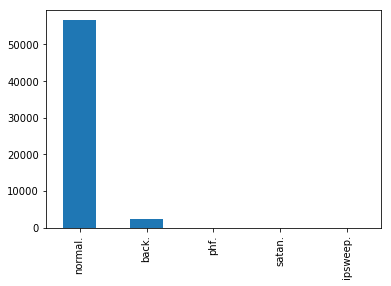

In [5]:
#https://thisdata.com/blog/unsupervised-machine-learning-with-one-class-support-vector-machines/
%matplotlib inline

import numpy as np  
import pandas as pd  
from sklearn import utils  
import matplotlib

col = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 
'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 
 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','label']

data = pd.read_csv('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz', names = col)

# extract just the logged-in HTTP accesses from the data
data = data[data['service'] == "http"]  
data = data[data["logged_in"] == 1]
data.label.value_counts().plot(kind='bar')  

# the full dataset contains features for SMTP, NDP, ICMP, etc.
# here we'll grab just the relevant features for HTTP.
relevant_features = [  
    "duration",
    "src_bytes",
    "dst_bytes",
    "label"
]

# replace the data with a subset containing only the relevant features
data = data[relevant_features]
data.head()

In [6]:

# normalise the data - this leads to better accuracy and reduces numerical instability in
# the SVM implementation
data["duration"] = np.log((data["duration"] + 0.1).astype(float))  
data["src_bytes"] = np.log((data["src_bytes"] + 0.1).astype(float))  
data["dst_bytes"] = np.log((data["dst_bytes"] + 0.1).astype(float))  

# we're using a one-class SVM, so we need.. a single class. the dataset 'label'
# column contains multiple different categories of attacks, so to make use of 
# this data in a one-class system we need to convert the attacks into
# class 1 (normal) and class -1 (attack)
data.loc[data['label'] == "normal.", "attack"] = 1  
data.loc[data['label'] != "normal.", "attack"] = -1

# grab out the attack value as the target for training and testing. since we're
# only selecting a single column from the `data` dataframe, we'll just get a
# series, not a new dataframe
target = data['attack']

target.head()


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: attack, dtype: float64

In [7]:

# find the proportion of outliers we expect (aka where `attack == -1`). because 
# target is a series, we just compare against itself rather than a column.
outliers = target[target == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", outliers.shape[0]/target.shape[0])

# drop label columns from the dataframe. we're doing this so we can do 
# unsupervised training with unlabelled data. we've already copied the label
# out into the target series so we can compare against it later.
data.drop(["label", "attack"], axis=1, inplace=True)

# check the shape for sanity checking.
print(data.shape)


#split data
from sklearn.model_selection import train_test_split  
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)  
train_data.shape 



outliers.shape (2209,)
outlier fraction 0.03761600681140911
(58725, 3)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(46980, 3)

In [8]:

#SVM params
# nu - what is the proportion of outliers we expect in the data
# kernel -- type: linear, rbf
#gamma - param of the RBF kernel type and controls the influence of individual training samples
# this affects the smoothnees of the model. Low has low var, high bias, high is high var, low bias

from sklearn import svm

# set nu (which should be the proportion of outliers in our dataset)
nu = outliers.shape[0] / target.shape[0]  
print("nu", nu)

model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)  
model.fit(train_data)

nu 0.03761600681140911


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.03761600681140911, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [11]:
#evaluate model for training set
from sklearn import metrics  
preds = model.predict(train_data)  
targs = train_target

print("training accuracy: ", metrics.accuracy_score(targs, preds))  
print("training precision: ", metrics.precision_score(targs, preds))  
print("training recall: ", metrics.recall_score(targs, preds))  
print("training f1: ", metrics.f1_score(targs, preds))  
print("training area under curve (auc): ", metrics.roc_auc_score(targs, preds))

print()
print()

#evaluate model for test set
preds = model.predict(test_data)  
targs = test_target

print("test accuracy: ", metrics.accuracy_score(targs, preds))  
print("test precision: ", metrics.precision_score(targs, preds))  
print("test recall: ", metrics.recall_score(targs, preds))  
print("test f1: ", metrics.f1_score(targs, preds))  
print("test area under curve (auc): ", metrics.roc_auc_score(targs, preds))  

training accuracy:  0.940655598127
training precision:  0.961500773033
training recall:  0.977421140011
training f1:  0.969395595952
training area under curve (auc):  0.498959877485


test accuracy:  0.947296722009
test precision:  0.965607087024
test recall:  0.980336830967
test f1:  0.972916210895
test area under curve (auc):  0.500069405583
